# MODELISATION ET EVALUATION

**Q1. Pourquoi organiser ses imports en début de notebook ?**

R1. Cela garantit que tout le code bénéficie des mêmes dépendances et facilite la lecture, la vérification et la maintenance du notebook. On évite aussi les erreurs inattendues dues à un mauvais ordre d’imports.

**Q2. Pourquoi avoir configuré les warnings (UndefinedMetricWarning) et le seed (RANDOM_STATE) ?**

R2. Filtrer les warnings permet d’obtenir un notebook propre, surtout avec des modèles baselines comme DummyClassifier. Mettre un seed assure la reproductibilité de tous mes résultats de cross-validation et d’entraînement, ce qui est essentiel en science des données.

**Q3. À quoi servent les scorers personnalisés dans la cross-validation ?**

R3. Définir des scorers avec zero_division=0 évite les divisions par zéro et clarifie l’attribution du score dans le cas où aucune classe positive n’est prédite, ce qui est fréquent sur des jeux de données déséquilibrés ou pour des modèles baselines.

In [11]:
# ============================================================
# IMPORTS ET CONFIGURATION
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.exceptions import UndefinedMetricWarning

### Pipelines et préprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Modèles et évaluation
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, cross_val_predict



### Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

### Evaluation

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_auc_score, classification_report,
    make_scorer, precision_score, recall_score, f1_score,fbeta_score, accuracy_score
)

f10_scorer = make_scorer(fbeta_score, beta=10, zero_division=0)


scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'f10': f10_scorer
}

# Configuration
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
plt.style.use('seaborn-v0_8')

RANDOM_STATE = 42


In [12]:
# ============================================================
# CHARGEMENT ET PRÉPARATION DES DONNÉES
# ============================================================

# Charger le dataset exporter depuis le notebook d'exploration

df  = pd.read_csv('exports/dataset_export.csv')

## Préparation des données pour le modèle
## Conversion de la colonne 'augementation_salaire_precedente' en numérique

df['augementation_salaire_precedente'] = pd.to_numeric(
    df['augementation_salaire_precedente'].str.replace('%', '').str.strip(), 
    errors='coerce'
)



In [13]:
df

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,sous_utilisation_competences,satisfaction_moyenne,nb_domaines_insatisfaits,score_surcharge,chute_performance,demotivation_performeur,manque_developpement,performeur_stagnant,parent_burnout,nb_signaux_alerte
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,2.666667,2.00,3,2,0,1.00,6.000000,0,0,3
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3.333333,3.00,1,0,-2,1.00,2.500000,0,0,0
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3.500000,3.00,1,2,-1,0.00,0.000000,0,0,1
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,4.000000,3.25,0,2,0,-0.25,2.000000,0,0,1
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3.000000,2.50,2,0,0,0.50,0.500000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,36,M,2571,Marié(e),Consulting,Consultant,4,80,17,...,5.666667,3.25,0,0,1,-0.25,1.250000,0,0,0
1466,2062,39,M,9991,Marié(e),Consulting,Manager,4,80,9,...,2.250000,2.25,2,0,-1,0.75,1.166667,0,0,1
1467,2064,27,M,6142,Marié(e),Consulting,Tech Lead,1,80,6,...,2.000000,2.25,3,2,0,1.75,6.000000,0,0,3
1468,2065,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,80,17,...,5.666667,3.00,2,0,-1,0.00,2.250000,0,0,0


**Q1. Pourquoi séparer le jeu d’entraînement et le jeu de test ?**  
R1. On sépare les données pour évaluer la capacité des modèles à généraliser sur des exemples jamais vus. Cela évite la sur-optimisation sur le training set et permet de détecter l’overfitting.

**Q2. À quoi sert le préprocessing (normalisation, encodage…) avant d’entraîner les modèles ?**  
R2. Le préprocessing harmonise les données (variables catégorielles, échelles différentes) pour que chaque modèle soit entraîné dans des conditions optimales, sans biais dû au format ou à la distribution initiale.

**Q3. Pourquoi documenter les étapes de préparation (imputation, sélection des features…) ?**  
R3. Ces étapes affectent directement la performance du modèle. Les décrire montre que le dataset a été nettoyé et préparé consciencieusement, ce qui renforce la crédibilité et la reproductibilité de mon travail.

In [14]:
# Définition complète des colonnes par catégorie

identifier_vars = ['id_employee']

target_var = 'attrition'

binary_vars = [
    'genre', 'statut_marital', 
    'heure_supplementaires', 'ayant_enfants'
]

categorical_vars = [
    'poste', 'domaine_etude', 'distance_categorie',
    'frequence_deplacement', 'departement'
]

numeric_vars = [
    'age', 'revenu_mensuel', 'nombre_experiences_precedentes',
    'nombre_heures_travailless', 'annee_experience_totale',
    'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel',
    'satisfaction_employee_environnement', 'note_evaluation_precedente',
    'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso',
    'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies',
    'nombre_employee_sous_responsabilite', 'distance_domicile_travail',
    'niveau_education', 'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel', 'surqualification',
    'profil_risque_heures_sup_dept', 'stagnation_carriere',
    'sous_utilisation_competences', 'satisfaction_moyenne',
    'nb_domaines_insatisfaits', 'score_surcharge', 'chute_performance',
    'demotivation_performeur', 'manque_developpement',
    'performeur_stagnant', 'parent_burnout', 'nb_signaux_alerte',
    'augementation_salaire_precedente'
]

columns_to_use = binary_vars + categorical_vars + numeric_vars

In [15]:
# Séparer features et target
X = df[columns_to_use]
y = df['attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Preprocessing pipeline
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), binary_vars + categorical_vars),
    (StandardScaler(), numeric_vars))


**Q1. Pourquoi avoir créé une fonction d’évaluation centralisée pour les modèles ?**  
R1. Cela évite la duplication de code, réduit les risques d’erreur et garantit que tous les modèles sont évalués avec la même méthodologie (cross-validation, test final, métriques affichées).

**Q2. À quoi sert la fonction d’interprétation de la matrice de confusion ?**  
R2. Elle permet une lecture qualitative (en plus des métriques quantitatives) pour comprendre les types d’erreurs du modèle : combien de vrais positifs, faux négatifs, etc. C’est important pour l’explicabilité, notamment dans des contextes métier sensibles.

**Q3. Pourquoi automatiser le reporting des scores et visualisations ?**  
R3. Cela accélère la comparaison entre modèles. La visualisation synthétise l’information et permet de repérer rapidement quel modèle surpasse les autres, et sur quels aspects.


In [16]:
# ============================================================
# FONCTIONS UTILITAIRES
# ============================================================

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cv=5):
    """
    Phase 1 : Cross-validation pour COMPARER les modèles
    Phase 2 : Test final pour ÉVALUER le modèle choisi (optionnel ici)
    """
    
    print(f"\n{'='*60}")
    print(f"MODÈLE : {model_name}")
    print(f"{'='*60}")
    
    # ============================================================
    # PHASE 1 : CROSS-VALIDATION (pour la comparaison)
    # ============================================================
    print(f"\n📊 PHASE 1 : COMPARAISON via Cross-Validation")
    print(f"{'='*60}")
    
    # Métriques CV
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
    
    # Prédictions CV pour matrice de confusion
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    
    # ⭐ MÉTRIQUES CV (pour comparer les modèles)
    print(f"\n--- Métriques Cross-Validation ({cv} folds sur {len(X_train)} échantillons) ---")
    print(f"👉 Utilise CES métriques pour comparer les modèles !")
    print(f"\nAUC : {cv_results['test_roc_auc'].mean():.3f} (+/- {cv_results['test_roc_auc'].std():.3f})")
    print(f"Accuracy : {cv_results['test_accuracy'].mean():.3f} (+/- {cv_results['test_accuracy'].std():.3f})")
    print(f"Precision : {cv_results['test_precision'].mean():.3f} (+/- {cv_results['test_precision'].std():.3f})")
    print(f"Recall : {cv_results['test_recall'].mean():.3f} (+/- {cv_results['test_recall'].std():.3f})")
    print(f"F1-score : {cv_results['test_f1'].mean():.3f} (+/- {cv_results['test_f1'].std():.3f})")
    if 'test_f10' in cv_results:
        print(f"F10-score : {cv_results['test_f10'].mean():.3f} (+/- {cv_results['test_f10'].std():.3f})")
    
    # ⭐ MATRICE DE CONFUSION CV (pour comparer les modèles)
    cm_cv = confusion_matrix(y_train, y_train_pred_cv)
    print(f"\n📊 Matrice de Confusion Cross-Validation")
    print(f"({len(X_train)} échantillons - POUR COMPARER LES MODÈLES)")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_cv, 
                                    display_labels=['Pas de démission', 'Démission'])
    disp.plot(cmap='Blues')
    plt.title(f'Matrice CV (Comparaison) - {model_name}\n{len(X_train)} échantillons train')
    plt.show()
    
    print("\n=== Interprétation CV (pour comparaison) ===")
    interpreter_matrice_confusion(y_train, y_train_pred_cv)

    # ============================================================
    # PHASE 2 : TEST FINAL (optionnel - juste pour information)
    # ============================================================
    print(f"\n{'='*60}")
    print(f"📊 PHASE 2 : ÉVALUATION FINALE (informative uniquement)")
    print(f"{'='*60}")
    print("⚠️  Ces métriques ne doivent PAS être utilisées pour comparer les modèles")
    print("    Elles servent uniquement à évaluer le modèle final choisi\n")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    test_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"--- Résultats sur test set ({len(X_test)} échantillons jamais vus) ---")
    if test_auc is not None:
        print(f"AUC Test : {test_auc:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Pas de démission', 'Démission']))
    
    cm_test = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                    display_labels=['Pas de démission', 'Démission'])
    disp.plot(cmap='Greens')
    plt.title(f'Matrice Test Final - {model_name}\n{len(X_test)} échantillons (informatif)')
    plt.show()
    
    interpreter_matrice_confusion(y_test, y_pred)

    # ============================================================
    # RÉSULTATS (priorité aux métriques CV)
    # ============================================================
    output = {
        'model_name': model_name,
        # ⭐ Métriques CV (pour la comparaison)
        'cv_auc_mean': cv_results['test_roc_auc'].mean(),
        'cv_auc_std': cv_results['test_roc_auc'].std(),
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_precision_mean': cv_results['test_precision'].mean(),
        'cv_recall_mean': cv_results['test_recall'].mean(),
        'cv_f1_mean': cv_results['test_f1'].mean(),
        'confusion_matrix_cv': cm_cv,  # ⭐ Pour comparaison
        # Métriques test (informatif seulement)
        'test_auc': test_auc,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix_test': cm_test,
        'model': model
    }
    
    if 'test_f10' in cv_results:
        output['cv_f10_mean'] = cv_results['test_f10'].mean()

    return output

def interpreter_matrice_confusion(y_true, y_pred):
    """
    Interprète la matrice de confusion pour un problème de démission
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\n=== Interprétation de la Matrice de Confusion ===")
    print(f"Vrais Négatifs (TN): {tn} - Employés qui ne démissionnent pas et correctement prédits")
    print(f"Faux Positifs (FP): {fp} - Employés qui NE démissionnent PAS mais prédits comme démissionnaires")
    print(f"Faux Négatifs (FN): {fn} - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)")
    print(f"Vrais Positifs (TP): {tp} - Employés qui démissionnent et correctement prédits")
    print(f"\nTotal de prédictions: {tn + fp + fn + tp}")
    print(f"Démissions réelles dans le test: {tp + fn}")
    print(f"Démissions prédites: {tp + fp}")
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
        print(f"\nPrécision: {precision:.3f} - Parmi ceux prédits comme démissionnaires, {precision*100:.1f}% le sont vraiment")
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
        print(f"Recall (Sensibilité): {recall:.3f} - Le modèle détecte {recall*100:.1f}% des démissions réelles")
    if (tn + fp) > 0:
        specificity = tn / (tn + fp)
        print(f"Spécificité: {specificity:.3f} - Le modèle identifie {specificity*100:.1f}% des non-démissions")


**Q1. Pourquoi intégrer à la fois des baselines (DummyClassifier) et des modèles plus complexes (LogisticRegression, KNN, LightGBM) ?**  
R1. Les baselines posent une référence minimale : tout vrai modèle doit faire mieux. Les modèles complexes sont testés pour vérifier qu’ils apportent un gain réel sur le problème et permettent d’étudier l’effet de la complexité.

**Q2. Pourquoi utiliser des pipelines pour certains modèles ?**  
R2. Les pipelines automatisent le préprocessing et l’entraînement en une seule étape, ce qui garantit un workflow cohérent et évite d’appliquer le préprocessing séparément pour chaque modèle.

**Q3. Comment choisir les modèles à comparer ?**  
R3. On sélectionne les modèles selon leur adéquation au problème (linéaire, non-linéaire, capacité à gérer le déséquilibre, etc.), leur popularité en data science et leur performance attendue sur le dataset.

In [17]:
# ============================================================
# DÉFINITION DES MODÈLES À COMPARER
# ============================================================
models = {
    'DummyClassifier (stratified)': DummyClassifier(strategy='stratified', random_state=RANDOM_STATE),
    'Logistic Regression': make_pipeline(preprocessor, LogisticRegression(class_weight='balanced',max_iter=1000,random_state=RANDOM_STATE)),
    'KNN': make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=5)),
    'LightGBM': make_pipeline(preprocessor, LGBMClassifier(objective='binary',class_weight='balanced',  # ← Gestion déséquilibre
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=RANDOM_STATE)),
    'SVM' : make_pipeline(preprocessor, SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
   
}


**Q1. Pourquoi utiliser la cross-validation pour chaque modèle ?**  
R1. La cross-validation donne une estimation robuste de la performance sur différents sous-ensembles de données. Cela réduit le risque qu’un résultat soit dû à une composition particulière du jeu d’entraînement.

**Q2. Que signifie comparer les scores CV et test ?**  
R2. Un modèle fiable doit avoir des scores similaires en cross-validation et sur le test set. Si la performance chute sur le test, c’est le signe d’un sur-apprentissage.

**Q3. Que permettent d’illustrer les matrices de confusion séparément ?**  
R3. Elles montrent la capacité du modèle à prédire chaque classe. Elles révèlent les éventuels biais (par exemple : sous-détection des démissions) qui pourraient ne pas apparaître dans les scores globaux.


MODÈLE : DummyClassifier (stratified)

📊 PHASE 1 : COMPARAISON via Cross-Validation

--- Métriques Cross-Validation (StratifiedKFold(n_splits=5, random_state=42, shuffle=True) folds sur 1102 échantillons) ---
👉 Utilise CES métriques pour comparer les modèles !

AUC : 0.505 (+/- 0.021)
Accuracy : 0.725 (+/- 0.011)
Precision : 0.180 (+/- 0.037)
Recall : 0.169 (+/- 0.035)
F1-score : 0.174 (+/- 0.036)
F10-score : 0.169 (+/- 0.035)

📊 Matrice de Confusion Cross-Validation
(1102 échantillons - POUR COMPARER LES MODÈLES)


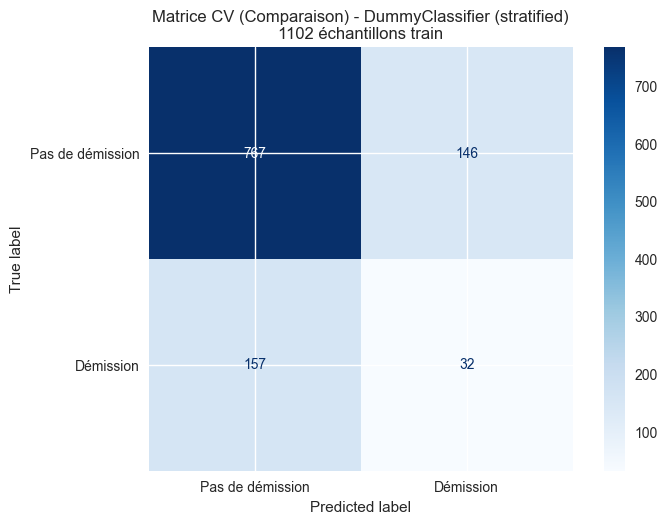


=== Interprétation CV (pour comparaison) ===

=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 767 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 146 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 157 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 32 - Employés qui démissionnent et correctement prédits

Total de prédictions: 1102
Démissions réelles dans le test: 189
Démissions prédites: 178

Précision: 0.180 - Parmi ceux prédits comme démissionnaires, 18.0% le sont vraiment
Recall (Sensibilité): 0.169 - Le modèle détecte 16.9% des démissions réelles
Spécificité: 0.840 - Le modèle identifie 84.0% des non-démissions

📊 PHASE 2 : ÉVALUATION FINALE (informative uniquement)
⚠️  Ces métriques ne doivent PAS être utilisées pour comparer les modèles
    Elles servent uniquement à évaluer le modèle final choisi

--- Résultats sur test set (368 échantillo

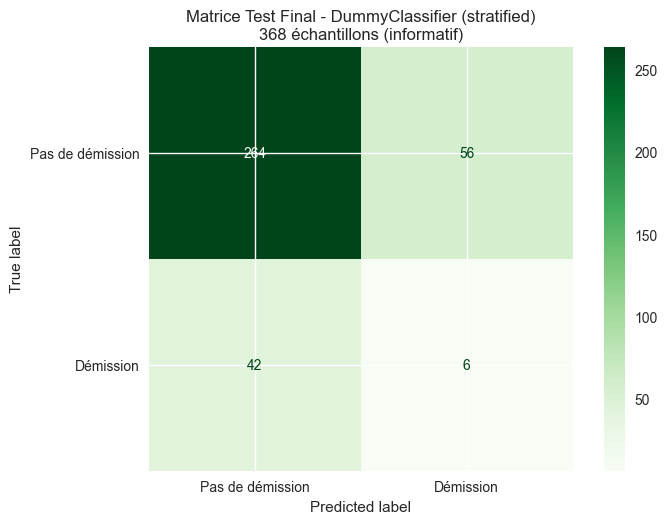


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 264 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 56 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 42 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 6 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 62

Précision: 0.097 - Parmi ceux prédits comme démissionnaires, 9.7% le sont vraiment
Recall (Sensibilité): 0.125 - Le modèle détecte 12.5% des démissions réelles
Spécificité: 0.825 - Le modèle identifie 82.5% des non-démissions

MODÈLE : Logistic Regression

📊 PHASE 1 : COMPARAISON via Cross-Validation

--- Métriques Cross-Validation (StratifiedKFold(n_splits=5, random_state=42, shuffle=True) folds sur 1102 échantillons) ---
👉 Utilise CES métriques pour comparer les modèles !

AUC : 0.832 (+/- 0.030)
Accuracy :

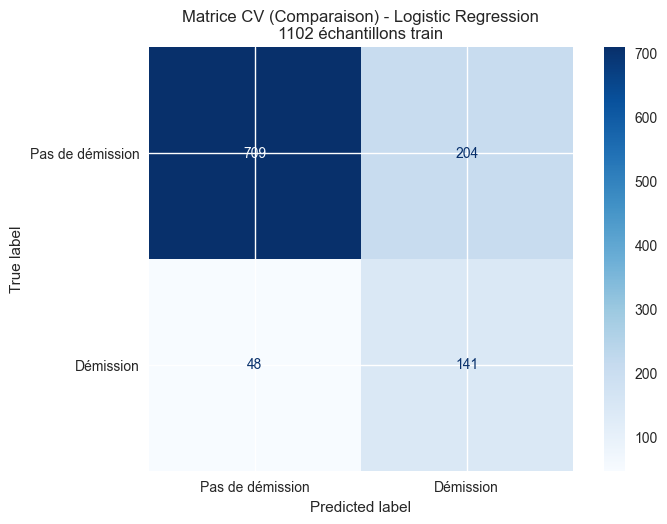


=== Interprétation CV (pour comparaison) ===

=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 709 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 204 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 48 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 141 - Employés qui démissionnent et correctement prédits

Total de prédictions: 1102
Démissions réelles dans le test: 189
Démissions prédites: 345

Précision: 0.409 - Parmi ceux prédits comme démissionnaires, 40.9% le sont vraiment
Recall (Sensibilité): 0.746 - Le modèle détecte 74.6% des démissions réelles
Spécificité: 0.777 - Le modèle identifie 77.7% des non-démissions

📊 PHASE 2 : ÉVALUATION FINALE (informative uniquement)
⚠️  Ces métriques ne doivent PAS être utilisées pour comparer les modèles
    Elles servent uniquement à évaluer le modèle final choisi

--- Résultats sur test set (368 échantillo

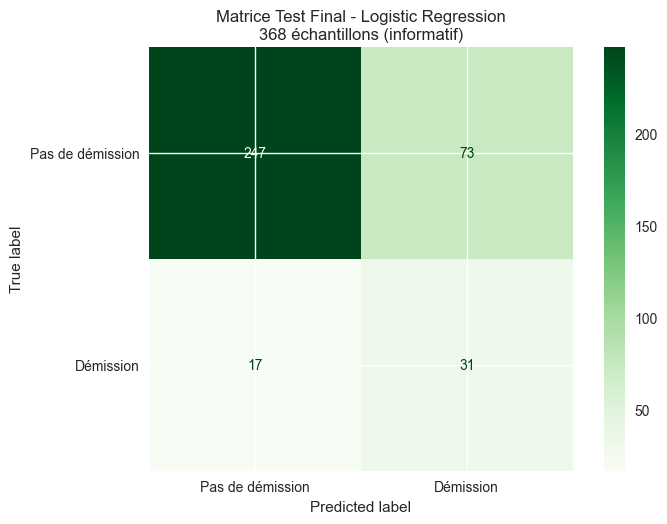


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 247 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 73 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 17 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 31 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 104

Précision: 0.298 - Parmi ceux prédits comme démissionnaires, 29.8% le sont vraiment
Recall (Sensibilité): 0.646 - Le modèle détecte 64.6% des démissions réelles
Spécificité: 0.772 - Le modèle identifie 77.2% des non-démissions

MODÈLE : KNN

📊 PHASE 1 : COMPARAISON via Cross-Validation

--- Métriques Cross-Validation (StratifiedKFold(n_splits=5, random_state=42, shuffle=True) folds sur 1102 échantillons) ---
👉 Utilise CES métriques pour comparer les modèles !

AUC : 0.722 (+/- 0.030)
Accuracy : 0.836 (+/- 0

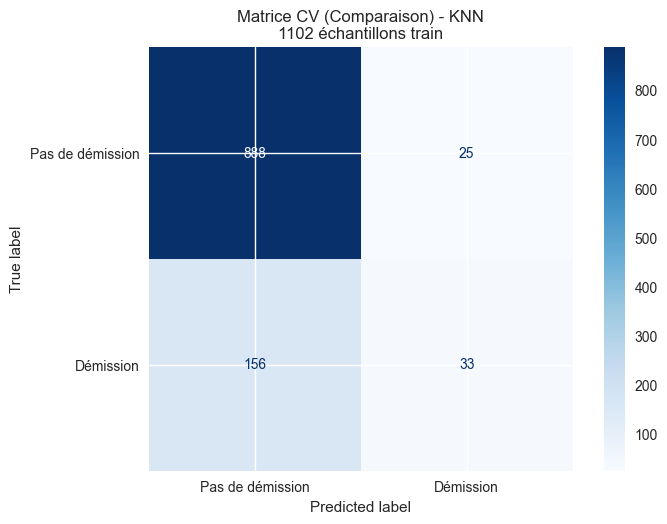


=== Interprétation CV (pour comparaison) ===

=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 888 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 25 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 156 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 33 - Employés qui démissionnent et correctement prédits

Total de prédictions: 1102
Démissions réelles dans le test: 189
Démissions prédites: 58

Précision: 0.569 - Parmi ceux prédits comme démissionnaires, 56.9% le sont vraiment
Recall (Sensibilité): 0.175 - Le modèle détecte 17.5% des démissions réelles
Spécificité: 0.973 - Le modèle identifie 97.3% des non-démissions

📊 PHASE 2 : ÉVALUATION FINALE (informative uniquement)
⚠️  Ces métriques ne doivent PAS être utilisées pour comparer les modèles
    Elles servent uniquement à évaluer le modèle final choisi

--- Résultats sur test set (368 échantillons

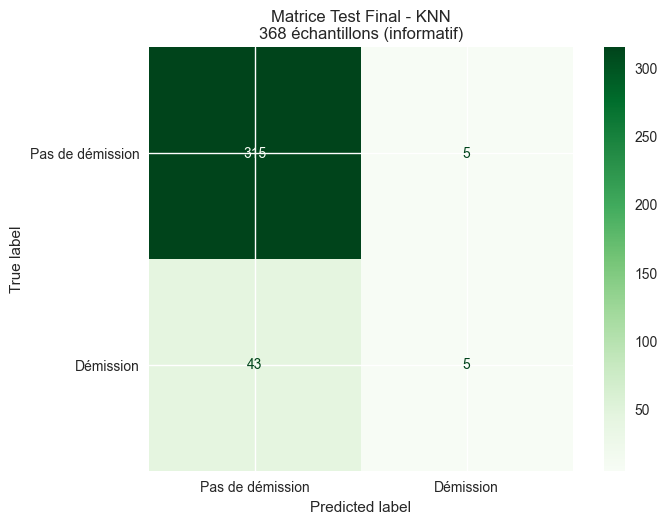


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 315 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 5 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 43 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 5 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 10

Précision: 0.500 - Parmi ceux prédits comme démissionnaires, 50.0% le sont vraiment
Recall (Sensibilité): 0.104 - Le modèle détecte 10.4% des démissions réelles
Spécificité: 0.984 - Le modèle identifie 98.4% des non-démissions

MODÈLE : LightGBM

📊 PHASE 1 : COMPARAISON via Cross-Validation
[LightGBM] [Info] Number of positive: 151, number of negative: 730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the over

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


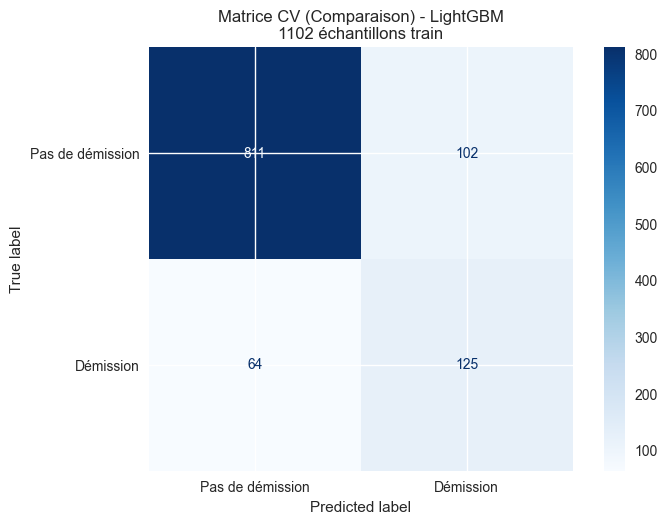


=== Interprétation CV (pour comparaison) ===

=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 811 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 102 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 64 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 125 - Employés qui démissionnent et correctement prédits

Total de prédictions: 1102
Démissions réelles dans le test: 189
Démissions prédites: 227

Précision: 0.551 - Parmi ceux prédits comme démissionnaires, 55.1% le sont vraiment
Recall (Sensibilité): 0.661 - Le modèle détecte 66.1% des démissions réelles
Spécificité: 0.888 - Le modèle identifie 88.8% des non-démissions

📊 PHASE 2 : ÉVALUATION FINALE (informative uniquement)
⚠️  Ces métriques ne doivent PAS être utilisées pour comparer les modèles
    Elles servent uniquement à évaluer le modèle final choisi

[LightGBM] [Info] Number of positive: 189,

/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


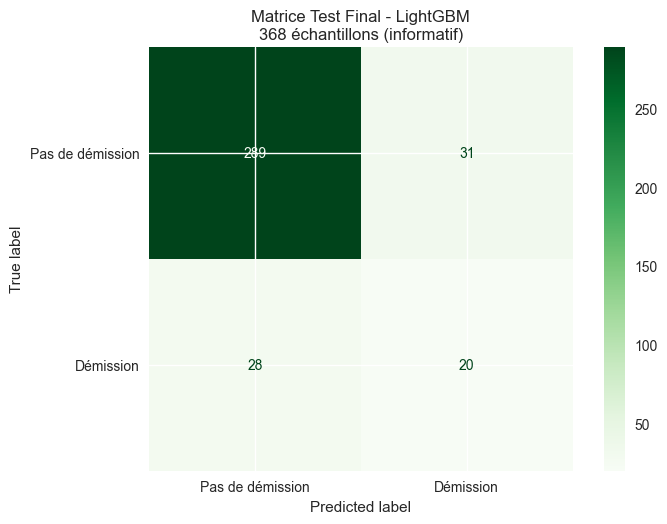


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 289 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 31 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 28 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 20 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 51

Précision: 0.392 - Parmi ceux prédits comme démissionnaires, 39.2% le sont vraiment
Recall (Sensibilité): 0.417 - Le modèle détecte 41.7% des démissions réelles
Spécificité: 0.903 - Le modèle identifie 90.3% des non-démissions

MODÈLE : SVM

📊 PHASE 1 : COMPARAISON via Cross-Validation

--- Métriques Cross-Validation (StratifiedKFold(n_splits=5, random_state=42, shuffle=True) folds sur 1102 échantillons) ---
👉 Utilise CES métriques pour comparer les modèles !

AUC : 0.828 (+/- 0.033)
Accuracy : 0.831 (+/- 0.

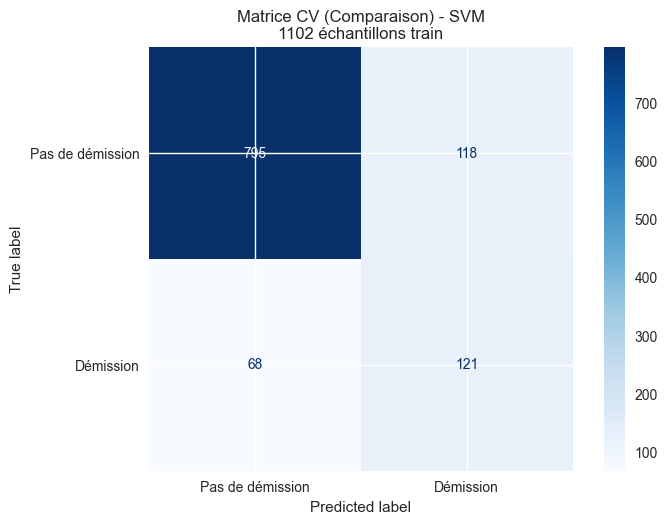


=== Interprétation CV (pour comparaison) ===

=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 795 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 118 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 68 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 121 - Employés qui démissionnent et correctement prédits

Total de prédictions: 1102
Démissions réelles dans le test: 189
Démissions prédites: 239

Précision: 0.506 - Parmi ceux prédits comme démissionnaires, 50.6% le sont vraiment
Recall (Sensibilité): 0.640 - Le modèle détecte 64.0% des démissions réelles
Spécificité: 0.871 - Le modèle identifie 87.1% des non-démissions

📊 PHASE 2 : ÉVALUATION FINALE (informative uniquement)
⚠️  Ces métriques ne doivent PAS être utilisées pour comparer les modèles
    Elles servent uniquement à évaluer le modèle final choisi

--- Résultats sur test set (368 échantillo

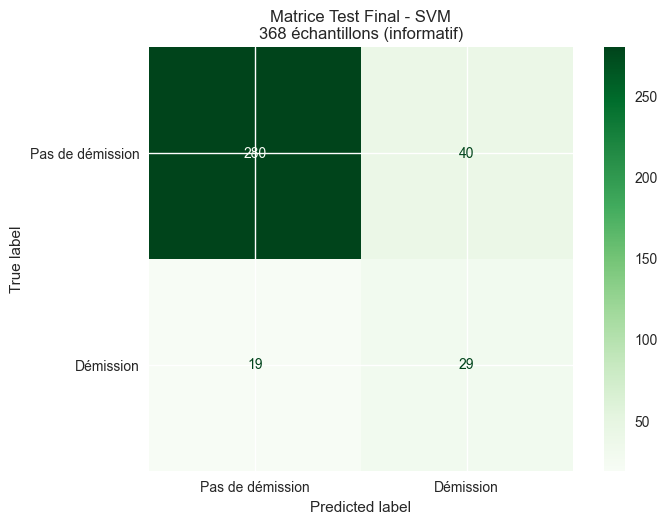


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 280 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 40 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 19 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 29 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 69

Précision: 0.420 - Parmi ceux prédits comme démissionnaires, 42.0% le sont vraiment
Recall (Sensibilité): 0.604 - Le modèle détecte 60.4% des démissions réelles
Spécificité: 0.875 - Le modèle identifie 87.5% des non-démissions


In [18]:
# ============================================================
# ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES
# ============================================================
results = []

for model_name, model in models.items():
    result = evaluate_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name=model_name,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    )
    results.append(result)


**Q1. Comment interpréter le tableau de comparaison des modèles ?**  
R1. Il permet de juger quel modèle surpasse les autres selon l’AUC, l’accuracy, le recall, etc. Un bon modèle doit avoir un bon compromis toutes métriques confondues, pas seulement un score maximal sur une métrique unique.

**Q2. Que permet la visualisation comparative (barplots des scores) ?**  
R2. Elle synthétise en un coup d’œil les écarts de performance entre modèles, et met en évidence la stabilité ou la dispersion des scores selon les folds de cross-validation.

**Q3. Pourquoi souligner explicitement le meilleur modèle choisi ?**  
R3. Cela démontre une démarche scientifique et rationnelle dans la prise de décision finale. Expliquer ce choix permet aussi de défendre l’intérêt de ce modèle pour une utilisation opérationnelle ou future.



📊 TABLEAU COMPARATIF DES MODÈLES (basé sur Cross-Validation)
👉 La sélection du meilleur modèle se fait sur les métriques CV
   Le test AUC est donné à titre informatif uniquement

                  model_name  cv_auc_mean  cv_auc_std  cv_accuracy_mean  cv_precision_mean  cv_recall_mean  cv_f1_mean     confusion_matrix_cv  test_auc  test_accuracy confusion_matrix_test  cv_f10_mean
         Logistic Regression     0.831947    0.030499          0.771259           0.415664        0.745946    0.532229 [[709, 204], [48, 141]]  0.788411       0.755435 [[247, 73], [17, 31]]     0.739946
                         SVM     0.828080    0.032657          0.831189           0.508209        0.639829    0.564927 [[795, 118], [68, 121]]  0.789225       0.839674 [[280, 40], [19, 29]]     0.638103
                    LightGBM     0.817280    0.039769          0.849367           0.551952        0.661166    0.600598 [[811, 102], [64, 125]]  0.758398       0.839674 [[289, 31], [28, 20]]     0.659819
       

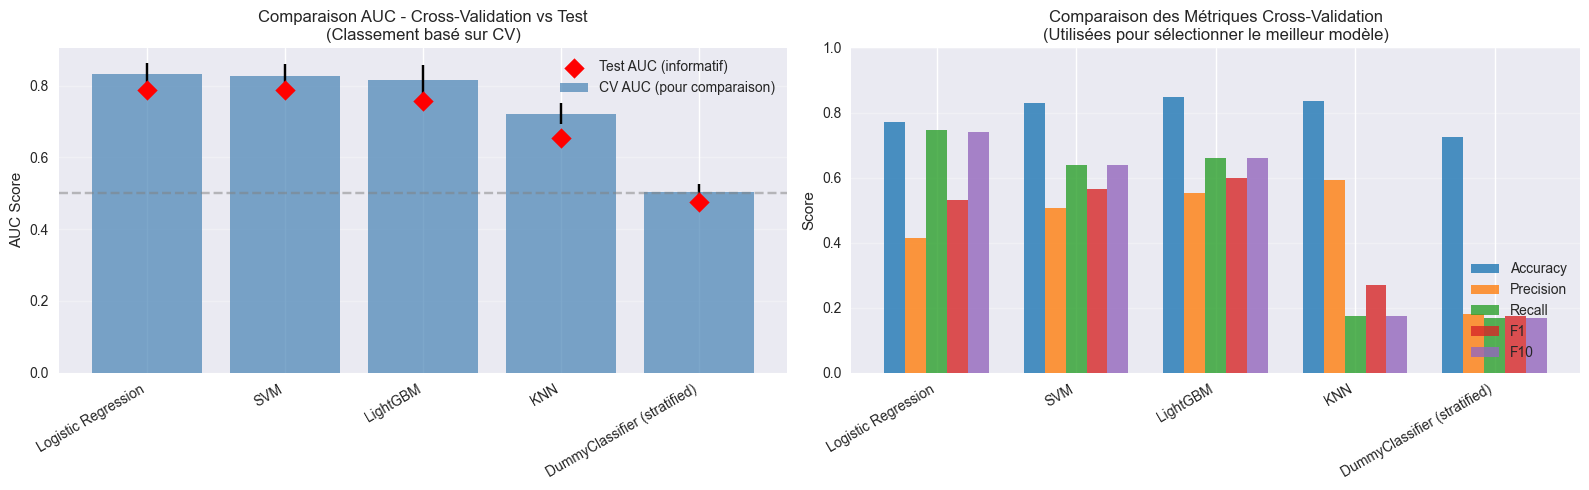


🏆 MEILLEUR MODÈLE (sélectionné sur CV AUC)
Modèle : Logistic Regression

--- Performances Cross-Validation (fiables pour comparaison) ---
  AUC CV       : 0.832 (+/- 0.030)
  Accuracy CV  : 0.771
  Precision CV : 0.416
  Recall CV    : 0.746
  F1 CV        : 0.532
  F10 CV       : 0.740

--- Performance Test Final (estimation généralisation) ---
  AUC Test     : 0.788

📊 ANALYSE : CV vs Test pour tous les modèles
Si grandes différences → possibles problèmes de surapprentissage/sous-apprentissage

                  model_name  cv_auc_mean  test_auc  diff_auc      interpretation
         Logistic Regression     0.831947  0.788411    -0.044            ✓ Stable
                         SVM     0.828080  0.789225    -0.039            ✓ Stable
                    LightGBM     0.817280  0.758398    -0.059 ⚠️ Surapprentissage
                         KNN     0.721820  0.654687    -0.067 ⚠️ Surapprentissage
DummyClassifier (stratified)     0.504611  0.475000    -0.030            ✓ Stable

Lége

In [20]:
# ============================================================
# COMPARAISON FINALE DES MODÈLES
# ============================================================

# Créer le DataFrame comparatif
results_df = pd.DataFrame(results)

# Vérifie et enlève la colonne 'model' si présente
if 'model' in results_df.columns:
    results_df = results_df.drop('model', axis=1)

# ⭐ IMPORTANT : Trie par AUC CV (pas test !) pour sélectionner le meilleur modèle
results_df = results_df.sort_values('cv_auc_mean', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("📊 TABLEAU COMPARATIF DES MODÈLES (basé sur Cross-Validation)")
print("="*80)
print("👉 La sélection du meilleur modèle se fait sur les métriques CV")
print("   Le test AUC est donné à titre informatif uniquement\n")
print(results_df.to_string(index=False))

# ==================== VISUALISATION ====================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ----- 1. Graphique AUC -----
ax1 = axes[0]
x_pos = np.arange(len(results_df))

# Barres bleues = CV (pour comparaison)
ax1.bar(x_pos, results_df['cv_auc_mean'], 
        yerr=results_df['cv_auc_std'], 
        alpha=0.7, capsize=10, label='CV AUC (pour comparaison)', 
        color='steelblue')

# Points rouges = Test (informatif)
ax1.scatter(x_pos, results_df['test_auc'], color='red', s=100, 
            label='Test AUC (informatif)', zorder=3, marker='D')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['model_name'], rotation=30, ha='right')
ax1.set_ylabel('AUC Score')
ax1.set_title('Comparaison AUC - Cross-Validation vs Test\n(Classement basé sur CV)')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline')

# ----- 2. Graphique métriques multiples (CV uniquement) -----
ax2 = axes[1]

# Liste des métriques CV à tracer
metrics_to_plot = [
    'cv_accuracy_mean', 
    'cv_precision_mean', 
    'cv_recall_mean', 
    'cv_f1_mean'
]

# Ajouter F10 si disponible
if 'cv_f10_mean' in results_df.columns and results_df['cv_f10_mean'].notna().any():
    metrics_to_plot.append('cv_f10_mean')

# Largeur des barres
width = 0.15  # Ajusté pour 4-5 barres

# Palette de couleurs
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Tracer chaque métrique avec bon décalage
for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - (len(metrics_to_plot)-1)/2)
    label = metric.replace('cv_', '').replace('_mean', '').replace('_', ' ').title()
    ax2.bar(x_pos + offset, results_df[metric], width, 
            label=label, color=colors[i % len(colors)], alpha=0.8)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['model_name'], rotation=30, ha='right')
ax2.set_ylabel('Score')
ax2.set_ylim([0, 1])
ax2.set_title('Comparaison des Métriques Cross-Validation\n(Utilisées pour sélectionner le meilleur modèle)')
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# AFFICHAGE DU MEILLEUR MODÈLE
# ============================================================
print("\n" + "="*80)
print("🏆 MEILLEUR MODÈLE (sélectionné sur CV AUC)")
print("="*80)
print(f"Modèle : {results_df.iloc[0]['model_name']}")
print(f"\n--- Performances Cross-Validation (fiables pour comparaison) ---")
print(f"  AUC CV       : {results_df.iloc[0]['cv_auc_mean']:.3f} (+/- {results_df.iloc[0]['cv_auc_std']:.3f})")
print(f"  Accuracy CV  : {results_df.iloc[0]['cv_accuracy_mean']:.3f}")
print(f"  Precision CV : {results_df.iloc[0]['cv_precision_mean']:.3f}")
print(f"  Recall CV    : {results_df.iloc[0]['cv_recall_mean']:.3f}")
print(f"  F1 CV        : {results_df.iloc[0]['cv_f1_mean']:.3f}")
if 'cv_f10_mean' in results_df.columns and pd.notna(results_df.iloc[0]['cv_f10_mean']):
    print(f"  F10 CV       : {results_df.iloc[0]['cv_f10_mean']:.3f}")

print(f"\n--- Performance Test Final (estimation généralisation) ---")
print(f"  AUC Test     : {results_df.iloc[0]['test_auc']:.3f}")
print("="*80)

# ============================================================
# TABLEAU COMPARATIF CV vs TEST (optionnel - pour analyse)
# ============================================================
print("\n" + "="*80)
print("📊 ANALYSE : CV vs Test pour tous les modèles")
print("="*80)
print("Si grandes différences → possibles problèmes de surapprentissage/sous-apprentissage\n")

comparison = results_df[['model_name', 'cv_auc_mean', 'test_auc']].copy()
comparison['diff_auc'] = (comparison['test_auc'] - comparison['cv_auc_mean']).round(3)
comparison['interpretation'] = comparison['diff_auc'].apply(
    lambda x: '✓ Stable' if abs(x) < 0.05 
    else ('⚠️ Surapprentissage' if x < -0.05 
    else '⚠️ Sous-apprentissage')
)

print(comparison.to_string(index=False))
print("\nLégende :")
print("  ✓ Stable : différence < 0.05 → modèle généralise bien")
print("  ⚠️ Surapprentissage : test << CV → modèle trop ajusté au train")
print("  ⚠️ Sous-apprentissage : test >> CV → modèle pas assez complexe")
print("="*80)